In [122]:
# !pip install torch
# !pip install torchvision

## Importing Libraries & Setting Device

- Importing PyTorch, torchvision, tqdm, NumPy, and Matplotlib for deep learning tasks.
- Checking for GPU availability to optimize computations.

```python
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [151]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [152]:
class FCVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(FCVAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim * 4)

        self.fc_mu = nn.Linear(hidden_dim * 4, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim * 4, latent_dim)

        # Latent to hidden
        self.z_fc = nn.Linear(latent_dim, hidden_dim * 4)
        
        # Decoder
        self.fc4 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
        self.fc5 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        return self.fc_mu(h3), self.fc_logvar(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.z_fc(z))
        h = torch.relu(self.fc4(h))
        h = torch.relu(self.fc5(h))
        x_recon = torch.sigmoid(self.fc6(h))
        return x_recon.view(-1, 3, 32, 32)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [153]:
# Conv VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(256)

        self.conv_mu = nn.Linear(256 * 2 * 2, latent_dim)
        self.conv_logvar = nn.Linear(256 * 2 * 2, latent_dim)
        self.z = nn.Linear(latent_dim, 256 * 2 * 2)
        
        # Decoder
        self.deconv1 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.debatch_norm1 = nn.BatchNorm2d(128)
        self.deconv2 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.debatch_norm2 = nn.BatchNorm2d(64)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.debatch_norm3 = nn.BatchNorm2d(32)
        self.deconv4 = nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1)

        self.leaky_relu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def encode(self, x):
        x = self.leaky_relu(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu(self.batch_norm4(self.conv4(x)))
        x = x.view(x.size(0), -1)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.z(z)
        x = x.view(-1, 256, 2, 2)
        x = self.leaky_relu(self.debatch_norm1(self.deconv1(x)))
        x = self.leaky_relu(self.debatch_norm2(self.deconv2(x)))
        x = self.leaky_relu(self.debatch_norm3(self.deconv3(x)))
        x = self.tanh(self.deconv4(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [154]:
# Loss function
def loss_function(recon_x, x, mu, logvar, beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD, MSE, KLD

In [155]:
# Training the VAE
def train(model, train_loader, optimizer, epoch, num_epochs, model_name, device):
    model.train()
    train_loss_total = 0
    recon_loss_total = 0
    kld_loss_total = 0
    with tqdm(train_loader, unit='batch', desc=f'Epoch {epoch}', colour='green') as tepoch:
        for batch_idx, (data, _) in enumerate(tepoch):
            if model_name == 'cvae':
                data = data.view(data.size(0), 3, 32, 32).to(device)
            elif model_name == 'fcvae':
                data = data.view(data.size(0), -1).to(device)   
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            if model_name == 'fcvae':
                recon_batch = recon_batch.view(-1, 3072)
            total_loss, recon_loss, kld_loss = loss_function(recon_batch, data, mu, logvar)
            total_loss.backward()
            train_loss_total += total_loss.item()
            recon_loss_total += recon_loss.item()
            kld_loss_total += kld_loss.item()
            optimizer.step()
            tepoch.set_postfix(
                train_loss=train_loss_total / len(train_loader.dataset),
                recon_loss=recon_loss_total / len(train_loader.dataset),
                kld_loss=kld_loss_total / len(train_loader.dataset)
            )
    print(f'Epoch {epoch}/{num_epochs} train loss: {train_loss_total / len(train_loader.dataset)} mse loss: {recon_loss_total / len(train_loader.dataset)} kld loss: {kld_loss_total / len(train_loader.dataset)}')

In [156]:
num_epochs = 10
lr = 1e-3

In [157]:
# Train the CVAE
transform_cvae = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_dataset_cvae = datasets.CIFAR10('./data/cvae', train=True, download=True, transform=transform_cvae)
train_loader_cvae = torch.utils.data.DataLoader(train_dataset_cvae, batch_size=64, shuffle=True)

cvae = ConvVAE(latent_dim=128).to(device)
optimizer_cvae = optim.Adam(cvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(cvae, train_loader_cvae, optimizer_cvae, epoch, num_epochs, 'cvae', device)

Files already downloaded and verified


Epoch 1:   5%|▍         | 37/782 [00:04<01:39,  7.49batch/s, kld_loss=1.4, recon_loss=33.1, train_loss=34.5]  


KeyboardInterrupt: 

In [ ]:
# Train the FCVAE
transform_fcvae = transforms.Compose([
    transforms.ToTensor()
])

train_dataset_fcvae = datasets.CIFAR10('./data/fcvae', train=True, download=True, transform=transform_fcvae)
train_loader_fcvae = torch.utils.data.DataLoader(train_dataset_fcvae, batch_size=64, shuffle=True)

fcvae = FCVAE(input_dim=3072, hidden_dim=1000, latent_dim=128)
optimizer_fcvae = optim.Adam(fcvae.parameters(), lr=lr)

for epoch in range(1, num_epochs + 1):
    train(fcvae, train_loader_fcvae, optimizer_fcvae, epoch, num_epochs, 'fcvae', device)

Files already downloaded and verified


Epoch 1: 100%|██████████| 782/782 [02:21<00:00,  5.54batch/s, kld_loss=6.92, recon_loss=131, train_loss=138]    


Epoch 1/10 train loss: 137.93474159179686 mse loss: 131.01731604492187 kld loss: 6.917425494756698


Epoch 2: 100%|██████████| 782/782 [03:36<00:00,  3.61batch/s, kld_loss=6.73, recon_loss=106, train_loss=113]     


Epoch 2/10 train loss: 112.81504838623047 mse loss: 106.08961566894531 kld loss: 6.725432772521972


Epoch 3: 100%|██████████| 782/782 [03:28<00:00,  3.75batch/s, kld_loss=7.14, recon_loss=99, train_loss=106]      


Epoch 3/10 train loss: 106.0964214453125 mse loss: 98.95917273925781 kld loss: 7.137248706054687


Epoch 4: 100%|██████████| 782/782 [03:25<00:00,  3.81batch/s, kld_loss=7.65, recon_loss=96.2, train_loss=104]    


Epoch 4/10 train loss: 103.87617292236328 mse loss: 96.22375467285157 kld loss: 7.652418130950927


Epoch 5: 100%|██████████| 782/782 [03:24<00:00,  3.83batch/s, kld_loss=8.86, recon_loss=90.6, train_loss=99.5]  


Epoch 5/10 train loss: 99.51081815185547 mse loss: 90.64790578857422 kld loss: 8.862912304382323


Epoch 6: 100%|██████████| 782/782 [03:24<00:00,  3.82batch/s, kld_loss=9.77, recon_loss=86.3, train_loss=96.1]  


Epoch 6/10 train loss: 96.10323221435547 mse loss: 86.3323294189453 kld loss: 9.77090276611328


Epoch 7: 100%|██████████| 782/782 [03:23<00:00,  3.84batch/s, kld_loss=9.93, recon_loss=85.2, train_loss=95.1]  


Epoch 7/10 train loss: 95.12514655517577 mse loss: 85.19874244140625 kld loss: 9.926404176940919


Epoch 8: 100%|██████████| 782/782 [03:26<00:00,  3.79batch/s, kld_loss=10.2, recon_loss=84.1, train_loss=94.3]  


Epoch 8/10 train loss: 94.29679741210937 mse loss: 84.05613520263672 kld loss: 10.240662258911133


Epoch 9: 100%|██████████| 782/782 [03:23<00:00,  3.84batch/s, kld_loss=10.8, recon_loss=81.5, train_loss=92.3]  


Epoch 9/10 train loss: 92.2981551196289 mse loss: 81.49989374511719 kld loss: 10.798261364440918


Epoch 10: 100%|██████████| 782/782 [03:24<00:00,  3.82batch/s, kld_loss=10.9, recon_loss=80.6, train_loss=91.5]  

Epoch 10/10 train loss: 91.52577458984375 mse loss: 80.57937017578125 kld loss: 10.946404441833495


In [130]:
# Function to generate and display new images
def generate_images(model, model_name, num_images, latent_dim):
    if np.sqrt(num_images) % 1 != 0:
        raise ValueError('num_images must be a perfect square')
    
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim).to(next(model.parameters()).device)
        # Decode these points to generate images
        generated_images = []
        for i in tqdm(range(num_images), desc='Generating images', unit='image', colour='blue'):
            generated_image = model.decode(z[i:i+1]).cpu()
            generated_images.append(generated_image)
    # Convert the generated images to a single tensor
    generated_images = torch.cat(generated_images, dim=0)

    if model_name == 'cvae':
        # Rescale the images to the range [-1, 1]
        generated_images = (generated_images + 1) / 2

    # Rescale the images to the range [0, 1]
    generated_images = torch.clamp(generated_images, 0, 1)

    grid_size = int(np.sqrt(num_images))

    # Plot the generated images
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size + 1, grid_size + 1))
    axs = axs.flatten() if len(axs.shape) == 2 else axs
    for i in range(num_images):
        axs[i].imshow(generated_images[i].numpy().transpose(1, 2, 0))
        axs[i].axis('off')
    plt.show()

Images from FC VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 241.83image/s]


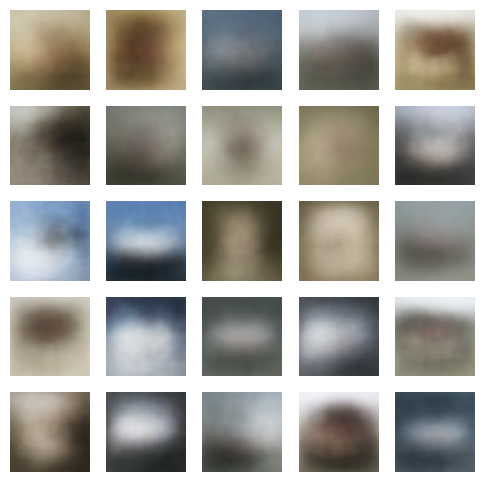

Images from Conv VAE


Generating images: 100%|██████████| 25/25 [00:00<00:00, 181.71image/s]


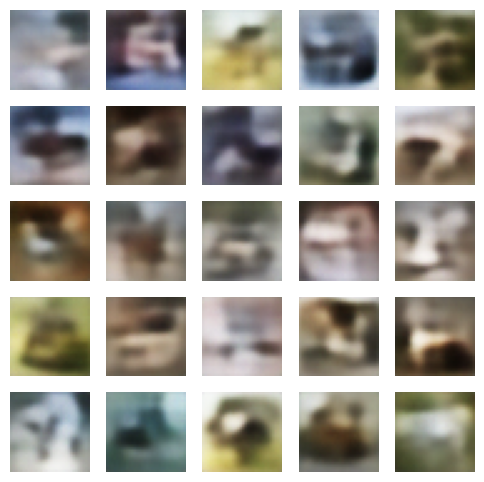

In [150]:
# Generate images
print('Images from FC VAE')
generate_images(fcvae, 'fcvae', num_images=25, latent_dim=128)

print('Images from Conv VAE')
generate_images(cvae, 'cvae', num_images=25, latent_dim=128)

In [132]:
def interpolate_images(model, model_name, image1, image2, device, num_steps=10):
    model.eval()
    with torch.no_grad():
        if model_name == 'cvae':
            if image1.shape[1] == 1:
                image1 = image1.repeat(1, 3, 1, 1)
            if image2.shape[1] == 1:
                image2 = image2.repeat(1, 3, 1, 1)
        image1 = image1.to(device)
        image2 = image2.to(device)
        mu1, logvar1 = model.encode(image1)
        mu2, logvar2 = model.encode(image2)
        z1 = model.reparameterize(mu1, logvar1)
        z2 = model.reparameterize(mu2, logvar2)
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_steps):
            interpolated_z = alpha * z2 + (1 - alpha) * z1
            reconstructed_image = model.decode(interpolated_z).cpu()
            if model_name == 'cvae':
                reconstructed_image = (reconstructed_image + 1) / 2
            interpolated_images.append(reconstructed_image)
        interpolated_images = torch.cat(interpolated_images, dim=0)
        return torch.clamp(interpolated_images, 0, 1)

In [133]:
def visualize_interpolation(model, model_name, dataset, num_steps=10):
    data_iter = iter(dataset)
    image1, _ = next(data_iter)
    image2, _ = next(data_iter)
    image1 = image1.unsqueeze(0).to(device)  # No need to flatten the image
    image2 = image2.unsqueeze(0).to(device)  # No need to flatten the image
    # Ensure 3 channels before passing to the model
    if image1.shape[1] == 1:
        image1 = image1.repeat(1, 3, 1, 1)  # Convert grayscale to RGB if necessary
    if image2.shape[1] == 1:
        image2 = image2.repeat(1, 3, 1, 1)  # Convert grayscale to RGB if necessary
    interpolated_images = interpolate_images(model, model_name, image1, image2, device, num_steps=num_steps)
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps, 1))
    for i in range(num_steps):
        axs[i].imshow(interpolated_images[i].permute(1, 2, 0).cpu().numpy())
        axs[i].axis('off')
    plt.show()

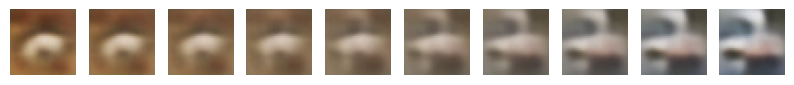

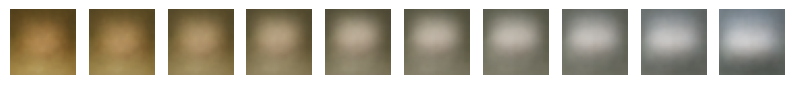

In [ ]:
# Interpolate between two images from the dataset for Conv VAE
visualize_interpolation(cvae, 'cvae', train_dataset_cvae, num_steps=10)

# Interpolate between two images from the dataset for FC VAE
visualize_interpolation(fcvae, 'fcvae', train_dataset_fcvae, num_steps=10)